In [1]:
import pandas as pd
import re
import struct
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

from scipy.signal import find_peaks
import matplotlib.colors as mcolors

current_dir = '/home/marian/CIGAR_ANALYSIS/CIGAR/notebooks'

# Build the absolute path to ../functions
functions_path = os.path.abspath(os.path.join(current_dir, '../functions'))

# Add it to sys.path
sys.path.append(functions_path)

import parse_data 
import cigar as cig

from tqdm import tqdm


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
colors = ['royalblue', 'crimson', 'black', 'green', 'darkorange', 'brown', 'coral', 'indigo', 'magenta', 'blue']


##  Data reading

In [3]:
run         = f'Run25'
temperature = f'{9}deg'
pressure    = 5.5

run_dir     = f"/home/marian/CIGAR_ANALYSIS/CIGAR/data/{run}"

nchannels       = 10
nevents_per_wvf = 500

samples_per_waveform = 752

event_header_bytes = 28
# event_header_bytes = 3036

# sample_binning = 1
sample_binning = 8e-9

nfiles = 20
start = 1

# offline_trg = None
offline_trg = 'AND'
# offline_trg = 'Majority3'

In [4]:
params = {'is_amplified':False,
          'amp_factors':{'CH1':269,
                         'CH2':267,
                         'CH3':258,
                         'CH4':275
                         },
            'pes':True,
            'temperature': temperature
          }

In [5]:
parse_data.checkWfs(run_dir, 
                    1, 10, 
                    nchannels, 
                    samples_per_waveform, 
                    event_header_bytes, 
                    print_headers = False
                    )

/home/marian/CIGAR_ANALYSIS/CIGAR/data/Run25
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)


In [6]:

# Initialize an empty list to store DataFrames
dataframes = []

# Loop through each folder and read all CSV files
for i, file in enumerate(tqdm(os.listdir(run_dir)[start:nfiles],desc="Reading .bin files", unit="file")):
    if file.endswith(".bin"):
        file_path = os.path.join(run_dir, file)
        # print(file_path)
        df = parse_data.parse_wf_from_binary(file_path, channels = nchannels, 
                                             n_events = nevents_per_wvf,
                                             file_idx = i,
                                             event_header_bytes = event_header_bytes
                                             )  
        dataframes.append(df)

Reading .bin files: 100%|██████████| 19/19 [00:43<00:00,  2.30s/file]


In [7]:
# Merge all DataFrames into one
merged_df = pd.concat(dataframes, ignore_index=True)
merged_df.tail()

,TIME,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,CH10,event,event_time,file_idx
7143995,0.000006,2.817178,2.758770,-369.438721,-527.491150,-410.200134,-539.879456,-352.060730,-606.357788,-408.822052,-593.677368,9499,467217420846,18
7143996,0.000006,2.694692,3.187912,-369.868805,-529.332520,-409.831482,-536.505981,-351.692596,-608.688538,-409.314148,-594.720520,9499,467217420846,18
7143997,0.000006,3.062150,3.065300,-368.701447,-536.759338,-409.155609,-538.100708,-351.140381,-612.797974,-408.452972,-593.247803,9499,467217420846,18
7143998,0.000006,2.694692,2.942688,-368.885773,-543.081421,-409.094147,-541.351562,-350.710907,-615.987427,-408.883545,-592.204651,9499,467217420846,18
7143999,0.000006,2.939664,2.758770,-369.192963,-548.605530,-408.909821,-545.277039,-350.772247,-619.238159,-408.637512,-589.811523,9499,467217420846,18


##  Data selection

In [8]:
# Filter for a specific event (change index as needed)
event_list  = merged_df['event'].unique()
nevents     = len(event_list)
print(f'Events per file = {len(event_list)/len(os.listdir(run_dir)[start:nfiles])}. Total nevents = {len(event_list)}')

Events per file = 500.0. Total nevents = 9500


In [9]:
if nchannels == 5:
    Amp_channels    = ['CH2', 'CH3', 'CH4', 'CH5'] # Amp
    noAmp_channels  = [] # noAmp

elif nchannels == 9:
    Amp_channels    = ['CH3', 'CH5', 'CH7', 'CH9'] # Amp
    noAmp_channels  = ['CH2', 'CH4', 'CH6', 'CH8'] # noAmp

elif nchannels == 10:
    Amp_channels    = ['CH4', 'CH6', 'CH8', 'CH10'] # Amp
    noAmp_channels  = ['CH3', 'CH5', 'CH7', 'CH9'] # noAmp

if params['is_amplified']:
    channels = Amp_channels
else:
    channels = noAmp_channels

all_channels    = noAmp_channels + Amp_channels


##  Noise filtering

In [10]:
# function to count number of peaks above threshold for one waveform
def count_high_peaks(group, channels_to_check, threshold=1000):
    peak_count = 0
    for ch in channels_to_check:
        peaks, _ = find_peaks(group[f'{ch}'].values, height=threshold)
        peak_count += len(peaks)
    return peak_count


In [11]:

# group by event (or event_time if that's more appropriate)
peak_counts      = merged_df.groupby("event").apply(count_high_peaks, channels_to_check=Amp_channels)

# keep only events with <= 5 peaks above 2000
valid_events     = peak_counts[peak_counts <= 4].index

# filter the original dataframe
filtered_df = merged_df[merged_df["event"].isin(valid_events)]

# update the number of valid events
event_list  = filtered_df['event'].unique()
nevents     = len(event_list)



/tmp/ipykernel_420598/343984057.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  peak_counts      = merged_df.groupby("event").apply(count_high_peaks, channels_to_check=Amp_channels)


##  Baseline correction

In [12]:
# DEFINITION OF THE BASELINE WINDOW WIDTH HERE
window_width = 10


In [13]:
corrected_df   = filtered_df.copy()
for i, ch in enumerate(all_channels):

    voltage = filtered_df[f'{all_channels[i]}'].values

    v_matrix                    = voltage.reshape(nevents, -1)
    v_matrix_corrected, _, _    = cig.BaselineCorrection(v_matrix, window=window_width)

    corrected_df[f'{all_channels[i]}'] = v_matrix_corrected.flatten()


In [14]:
corrected_df.tail()

,TIME,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,CH10,event,event_time,file_idx
7143243,0.000006,2.327234,29.917328,-0.165891,10.385303,1.210449,-77.215906,-0.932632,-8.464233,-0.990387,331.502081,9498,467201907415,18
7143244,0.000006,2.572206,29.610798,0.141299,12.963245,0.903229,-73.842432,-1.300766,-11.101624,-0.621307,316.897925,9498,467201907415,18
7143245,0.000006,2.572206,30.162552,-0.165891,17.198413,0.473114,-68.444849,-0.993973,-10.917664,-0.621307,300.146094,9498,467201907415,18
7143246,0.000006,2.449720,30.223858,0.018436,20.758411,0.104462,-65.255334,-0.932632,-10.856323,-0.436737,283.394263,9498,467201907415,18
7143247,0.000006,2.265991,30.039940,-0.964597,24.993518,-0.325653,-61.084497,-1.300766,-12.144348,-0.867340,264.494757,9498,467201907415,18


##  Offline trigger

In [15]:
# time_window_min = 1.8e-6 # [s]
# time_window_max = 3e-6 # [s]

# # time_window_min = 0.5e-6 # [s]
# # if params['is_amplified']:
# #     time_window_max = 2.5e-6 # [s]
# # else:
# #     time_window_max = 2e-6 # [s]


In [16]:
# min_th = 1000 # [mV] Amp
# # min_th = 0 # [mV]

# signal_th = {'CH1':min_th,
#              'CH2':min_th,
#              'CH3':min_th,
#              'CH4':min_th
#              } # [mV]

# if params['is_amplified'] == False:
#     for ch in params['amp_factors'].keys():
#         signal_th[ch] = signal_th[ch]/params['amp_factors'][ch]

# signal_th['CHSum'] = sum(signal_th.values())


In [17]:
# # AND artificial trigger
# def all_channels_above_threshold(group, channels_to_check, time_col='time', tmin=0, tmax=10, threshold=800):
#     """Return True if *all* channels exceed the threshold at least once within the time window."""
#     sub = group[(group[time_col] >= tmin) & (group[time_col] <= tmax)]
#     if sub.empty:
#         return False

#     # Check if each channel has any sample above threshold
#     above_flags = [(sub[ch] > list(threshold.values())[ii]).any() for ii, ch in enumerate(channels_to_check)]

#     # Only keep event if *all* channels exceed the threshold
#     return all(above_flags)

In [18]:
# # MAJORITY artificial trigger
# def at_least_n_channels_above_threshold(
#     group, channels_to_check, time_col='time', tmin=0, tmax=10, threshold=800, n_required=3
# ):
#     """Return True if at least n_required channels exceed the threshold within the time window."""
#     sub = group[(group[time_col] >= tmin) & (group[time_col] <= tmax)]
#     if sub.empty:
#         return False

#     # Check if each channel has any sample above threshold
#     above_flags = [(sub[ch] > threshold[ch]).any() for ch in channels_to_check]

#     # Keep event if at least n_required channels exceed threshold
#     return sum(above_flags) >= n_required


In [19]:
# # Apply per event
# valid_events_mask = corrected_df.groupby("event").apply(
#     all_channels_above_threshold,
#     channels_to_check=channels,
#     time_col="TIME",
#     tmin=time_window_min,
#     tmax=time_window_max,
#     threshold=signal_th
#     # ,n_required=3
# )

# # Extract valid events
# valid_response_events = valid_events_mask[valid_events_mask].index

# # Filter your dataframe
# final_df = corrected_df[corrected_df["event"].isin(valid_response_events)]

# # Update event list and count
# event_list = final_df["event"].unique()
# nevents = len(event_list)

In [20]:
# final_df = corrected_df

# # Update event list and count
# event_list = final_df["event"].unique()
# nevents = len(event_list)

##  Offline trigger

In [21]:
amplified = params['is_amplified']

In [22]:
# time_window_min = 1.5e-6 # [s]
# time_window_max = 3e-6 # [s]

time_window_min = 1.7e-6 # [s]
if amplified:
    time_window_max = 3.5e-6 # [s]
else:
    time_window_max = 3e-6 # [s]


In [23]:
min_th = 1000 # [mV]
# min_th = 0 # [mV]

signal_th = {'CH1':min_th,
             'CH2':min_th,
             'CH3':min_th,
             'CH4':min_th
             } # [mV]

if amplified == False:
    for ch in params['amp_factors'].keys():
        signal_th[ch] = signal_th[ch]/params['amp_factors'][ch]

signal_th['CHSum'] = sum(signal_th.values())


In [24]:
# AND artificial trigger
def all_channels_above_threshold(group, channels_to_check, time_col='time', tmin=0, tmax=10, threshold=800):
    """Return True if *all* channels exceed the threshold at least once within the time window."""
    sub = group[(group[time_col] >= tmin) & (group[time_col] <= tmax)]
    if sub.empty:
        return False

    # Check if each channel has any sample above threshold
    above_flags = [(sub[ch] > list(threshold.values())[ii]).any() for ii, ch in enumerate(channels_to_check)]

    # Only keep event if *all* channels exceed the threshold
    return all(above_flags)

In [25]:
# MAJORITY artificial trigger
def at_least_n_channels_above_threshold(
    group, channels_to_check, time_col='time', tmin=0, tmax=10, threshold=800, n_required=3
):
    """Return True if at least n_required channels exceed the threshold within the time window."""
    sub = group[(group[time_col] >= tmin) & (group[time_col] <= tmax)]
    if sub.empty:
        return False

    # Check if each channel has any sample above threshold
    above_flags = [(sub[ch] > list(threshold.values())[ii]).any() for ii, ch in enumerate(channels_to_check)]

    # Keep event if at least n_required channels exceed threshold
    return sum(above_flags) >= n_required


In [30]:
if offline_trg == 'AND':
    # Apply per event
    valid_events_mask = corrected_df.groupby("event").apply(
        all_channels_above_threshold,
        channels_to_check=channels,
        time_col="TIME",
        tmin=time_window_min,
        tmax=time_window_max,
        threshold=signal_th
    )
elif offline_trg == 'Majority3':
    # Apply per event
    valid_events_mask = corrected_df.groupby("event").apply(
        at_least_n_channels_above_threshold,
        channels_to_check=channels,
        time_col="TIME",
        tmin=time_window_min,
        tmax=time_window_max,
        threshold=signal_th,
        n_required=3
    )

if offline_trg == None:
    final_df = corrected_df
else:
    # Extract valid events
    valid_response_events = valid_events_mask[valid_events_mask].index

    # Filter your dataframe
    final_df = corrected_df[corrected_df["event"].isin(valid_response_events)]

    # Update event list and count and data info
    event_list = final_df["event"].unique()
    nevents = len(event_list)


/tmp/ipykernel_420598/3202706155.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  valid_events_mask = corrected_df.groupby("event").apply(


##  Sum calculation

In [31]:
final_df      = cig.CreateWfSum(final_df, channels, params)
channels.append('CHSum')

['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8', 'CH9', 'CH10']


/home/marian/CIGAR_ANALYSIS/CIGAR/functions/cigar.py:962: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wf['CHSum'] = sum(wf[ch] for ch in channels)


In [32]:
final_df.tail()


,TIME,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,CH10,CHSum,event,event_time,file_idx
7140987,0.000006,3.062150,26.484192,1.966077,15.332495,0.307208,311.991699,1.625946,75.043408,-0.467517,-3060.429726,3.431714,9495,466731711222,18
7140988,0.000006,3.000907,25.993744,1.658887,8.028357,0.921649,288.070648,1.994080,61.058972,-0.098437,-3063.804634,4.476178,9495,466731711222,18
7140989,0.000006,3.245879,25.503296,2.150403,3.547705,1.105975,269.424500,2.055420,48.853345,0.455212,-3072.027143,5.767010,9495,466731711222,18
7140990,0.000006,2.755935,26.055050,1.904645,4.100134,0.983112,256.543945,1.994080,39.714429,0.639752,-3085.772231,5.521588,9495,466731711222,18
7140991,0.000006,2.817178,25.993744,1.781750,4.959448,1.228870,244.951447,1.871368,33.090222,1.070355,-3103.137677,5.952344,9495,466731711222,18


##  Signal spectrum

In [33]:
t_matrix = final_df['TIME'].values.reshape(nevents, -1)
time     = t_matrix[0]

In [34]:
time_window      = (time_window_min < time)  & (time < time_window_max)

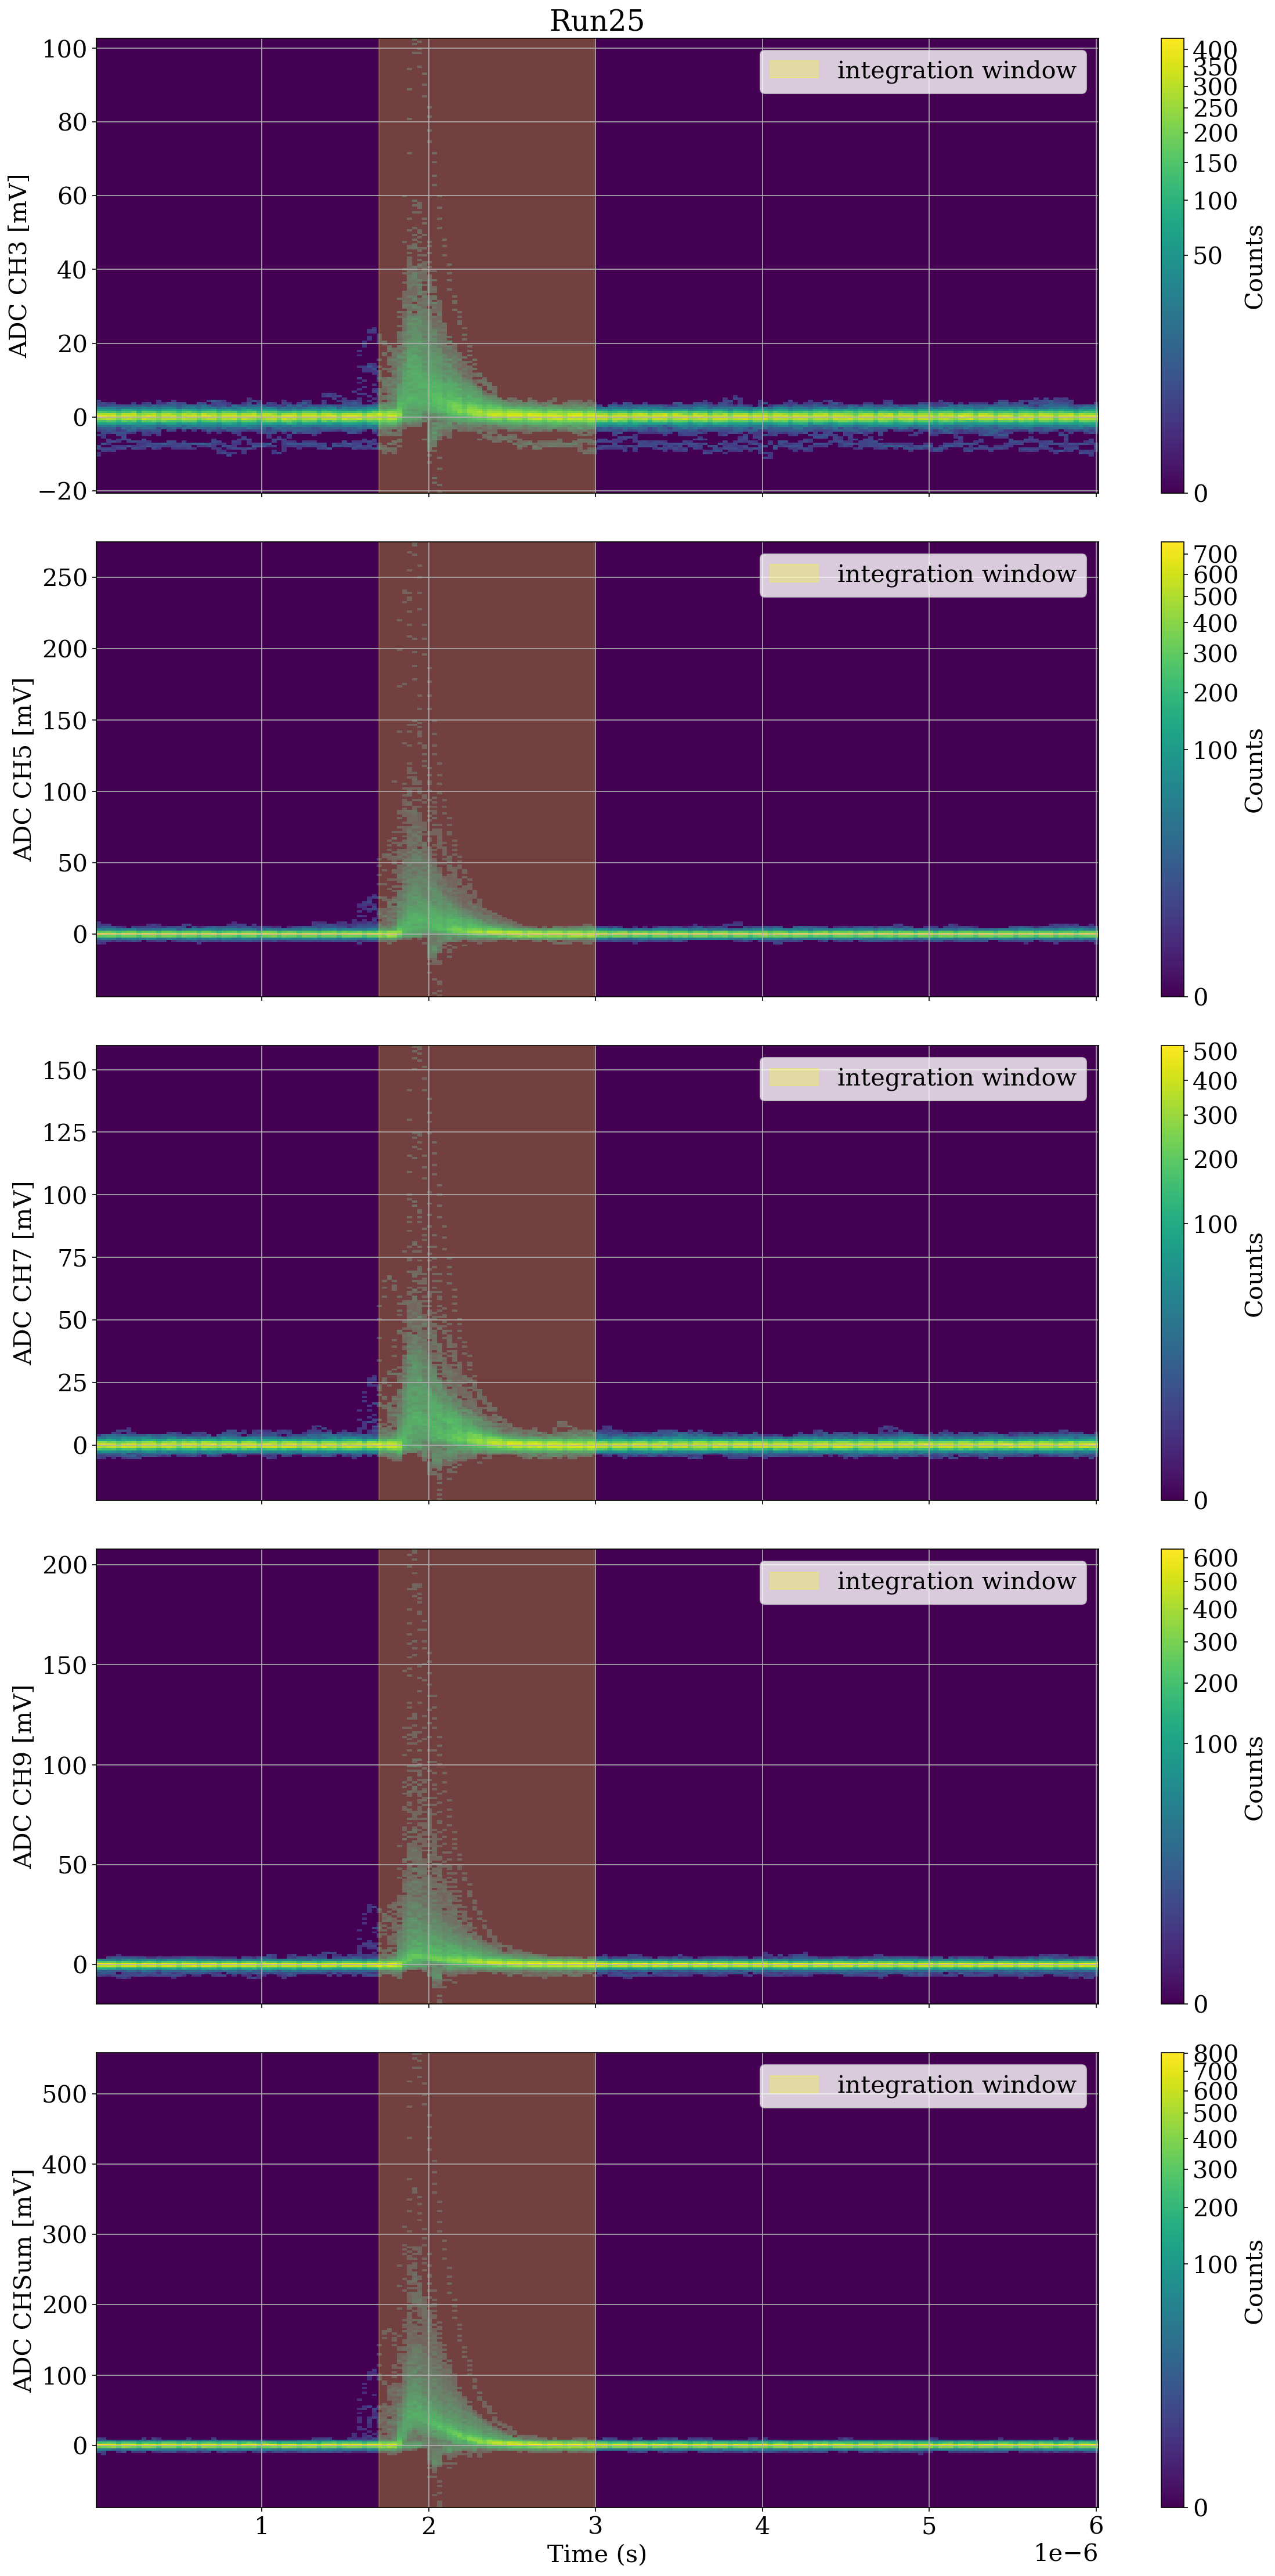

In [35]:
# Create subplots: 2 rows, 1 column

if len(channels) > 1:
    fig, axs = plt.subplots(len(channels), 1, figsize=(16, len(channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(channels) > 1:
    axs[0].set_title(f'{run}')
else:
    ax.set_title(f'{run}')


# Plot CHs
for i in range(len(channels)):

    if len(channels) > 1:
        ax = axs[i]

    voltage  = final_df[f'{channels[i]}'].values
    v_matrix = voltage.reshape(nevents, -1)
    # v_matrix_corrected, baselines, window = cig.BaselineCorrection(v_matrix, window=window_width)
    v_matrix_corrected = v_matrix
    
    # voltage_matrix = np.array([...]) # shape (nevents, nsamples)
    hb = ax.hist2d(t_matrix.flatten(), v_matrix_corrected.flatten(), bins=[200, 200], 
                   cmap='viridis', norm=mcolors.PowerNorm(gamma=0.3))

    fig.colorbar(hb[3], ax=ax, label="Counts")

    ax.fill_between(time[time_window], v_matrix_corrected.min(), v_matrix_corrected.max(), 
                    color = 'yellow', alpha = 0.25, label = 'integration window')

    ax.set_ylabel(f'ADC {channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

##  Charge spectrum

Run25 is 42.20 mins long


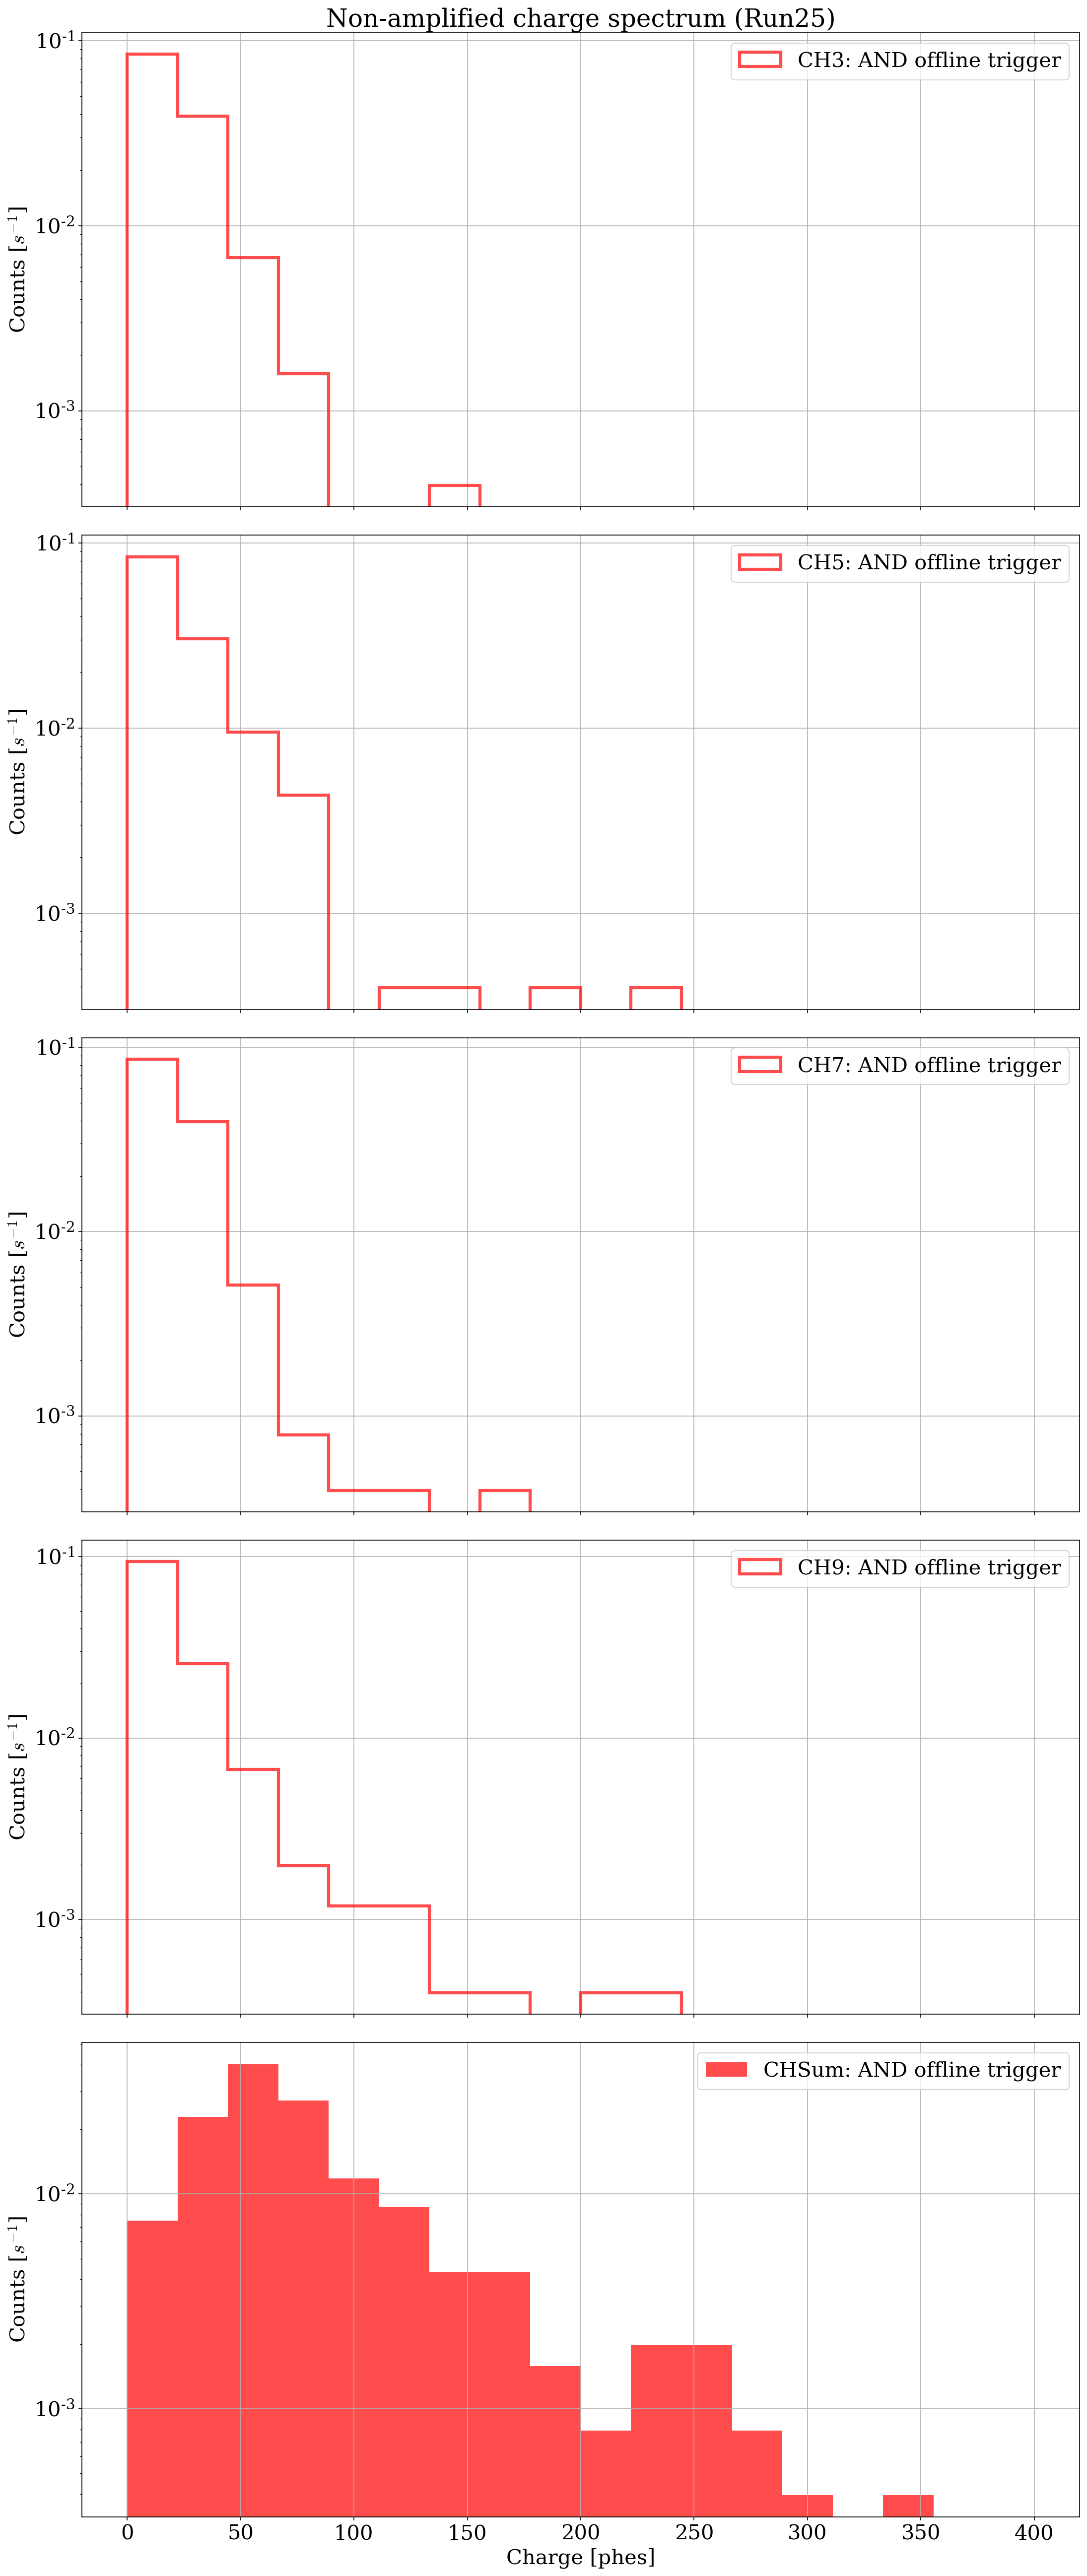

In [37]:
# Create subplots: 2 rows, 1 column

if len(channels) > 1:
    fig, axs = plt.subplots(len(channels), 1, figsize=(15, len(channels)*7), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(15, 7), dpi=150, sharex=True)

if len(channels) > 1:
    if params['is_amplified']:
        axs[0].set_title(f'Amplified charge spectrum ({run})')
    else:
        axs[0].set_title(f'Non-amplified charge spectrum ({run})')
else:
    if params['is_amplified']:
        ax.set_title(f'Amplified charge spectrum ({run})')
    else:
        ax.set_title(f'Non-amplified charge spectrum ({run})')

charge_Sum = 0


run_duration   = ((final_df.groupby('file_idx').max().event_time - final_df.groupby('file_idx').min().event_time)*8e-9).sum()
print(f"{run} is {run_duration/60:.2f} mins long")

# Plot CHs
for i, ch in enumerate(channels):

    if len(channels) > 1:
        ax = axs[i]
    
    voltage = final_df[f'{channels[i]}'].values

    v_matrix                    = voltage.reshape(nevents, -1)
    # v_matrix_corrected, _, _    = cig.BaselineCorrection(v_matrix, window=window_width)
    v_matrix_corrected = v_matrix

    charge = np.trapz(v_matrix_corrected[:, time_window]*1e-3,
                      x = time[time_window]
                      ,axis = 1)
    
    if params['pes']:
        if ch != 'CHSum':
            charge = cig.ChargeToPes(charge, channel=i+1, 
                                        temp = params['temperature'], amplified = params['is_amplified'], CHAmp=params['amp_factors'])
            charge_Sum = charge_Sum + charge
        else:
            charge = charge_Sum

    if ch == 'CHSum':
        hist_type = 'stepfilled'
    else:
        hist_type = 'step'
    events, bins, image = ax.hist(charge
                                ,bins = int(np.sqrt(len(charge))) 
                                ,range = (0, 400)
                                ,weights=np.ones_like(charge)/run_duration
                                ,density = False
                                ,histtype   =hist_type
                                ,color      = 'r'
                                ,ls         = '-'
                                ,lw         = 3
                                ,alpha      = 0.7
                                ,label = f'{ch}: {offline_trg} offline trigger'
                                )
    
    
    ax.set_ylabel(fr'Counts [$s^{{-1}}$]')
    ax.grid(True)
    ax.set_yscale('log')
    ax.legend()

if len(channels) > 1:
    if params['pes']:
        axs[-1].set_xlabel(r'Charge [phes]')
    else:
        axs[-1].set_xlabel(r'Charge [V $\cdot$ s]')
else:
    ax.set_xlabel(r'Charge [V $\cdot$ s]')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

In [38]:
# voltage = final_df[f'{channels[3]}'].values

# v_matrix                    = voltage.reshape(nevents, -1)
# # v_matrix_corrected, _, _    = cig.BaselineCorrection(v_matrix, window=window_width)
# v_matrix_corrected = v_matrix

# charge = np.trapz(v_matrix_corrected[:, time_window]*1e-3,
#                     x = time[time_window]
#                     ,axis = 1)

# d = cig.ChargeToPes(charge, channel=3+1, 
#                                         temp = params['temperature'], amplified = params['is_amplified'], CHAmp=params['amp_factors'])

In [ ]:
charge_Sum.min()

-13.5408252870697

: 

In [ ]:
save = False
if save:
    np.save(f'/home/marian/Downloads/{run}.npy', charge_Sum)